In [1]:
import QUANTAXIS as QA

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 14  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号

import numpy as np

import seaborn as sns

from base.JuUnits import excute_for_multidates
from base.Constants import trade_date_sse, LOW_FREQUENCE

import pandas as pd

###########modin#########################
###fit部分没有分布式优势，计算trend时有巨大优势。
### 对二级索引不友好，启用
# import base.Constants as con
# import modin.pandas as pd
# from distributed.security import Security
# from distributed import Client
# sec = Security(
#     tls_ca_file=con.DC_FILEPATH,
#     tls_client_cert=con.DC_FILEPATH,
#     tls_client_key=con.DK_FILEPATH,
#     require_encryption=True,
# )
# client = Client(f"tls://{con.DASK_HOST}", security=sec)
# from tqdm import tqdm
# from modin.config import ProgressBar
# ProgressBar.enable()
###########modin####################
    
class Block_Trend:
    """
        1.展示每个行业，平均以上的股票占比图
        2.获取变化趋势
    """
    def __init__(self,hy_source='tdxhy', end='2021-04-30', gap=60, start=None, frequence=QA.FREQUENCE.DAY, MA=20):
        self._hy_source=hy_source
        self.end = end
        self.gap = gap
        self.MA = MA
        if start is None:
            self.start = trade_date_sse[trade_date_sse.index(end)-self.gap]
        else:
            self.start = start
        self.blocks_view = self.get_blocks_view()
        self.pivot = None
        self.frequence = frequence
        self.trend = None
                
    @property
    def hy_source(self):
        return self._hy_source
    
    @hy_source.setter
    def hy_source(self, value):
        if not value in ['tdxhy','swhy','gn']:
            raise TypeError('hy_source MUST BE [tdxhy|swhy|gn]')
        self._hy_source=value
        self.blocks_view = self.get_blocks_view()
        
    @property
    def is_low_frequence(self):
        return self.frequence in LOW_FREQUENCE

    
    def fit(self, blocks=None):
        if blocks is None or blocks == 'all':
            ma_above = self.blocks_view.apply(self.check_MA_above)
        elif isinstance(blocks, list):
            ma_above = self.blocks_view[blocks].apply(self.check_MA_above)
        else:
            raise TypeError('fit(blocks) params error')
        tmp = ma_above.reset_index()
        if self.is_low_frequence:
            date_label = 'date'
        else:
            date_label = 'datetime'
        rebuid_df = pd.DataFrame({'blockname':tmp.blockname.repeat(tmp[0].str.len()),date_label:[i[0] for i in np.concatenate(tmp[0].values)],'-':[i[1] for i in np.concatenate(tmp[0].values)]})
        self.pivot = rebuid_df.pivot(index=date_label, columns='blockname')
        print('pivot fit finish')
        
    def get_blocks_view(self):
        a = QA.QA_fetch_stock_block_adv().data
        blocks_view = a[a['type'] == self._hy_source].groupby(level=0).apply(
            lambda x:[item for item in x.index.remove_unused_levels().levels[1]]
        )
        return blocks_view
    
    def check_MA_above(self, hy_codes):
        """计算均线以上的数量"""
        try:
#             data = QA.QA_quotation(hy_codes, self.start, self.end, source=QA.DATASOURCE.MONGO,
#                                frequence=self.frequence, market=QA.MARKET_TYPE.STOCK_CN,
#                                output=QA.OUTPUT_FORMAT.DATASTRUCT)
            if self.frequence == QA.FREQUENCE.DAY:
                data = QA.QA_fetch_stock_day_adv(hy_codes, self.start, self.end)
            else:
                data = QA.QA_fetch_stock_min_adv(hy_codes, self.start, self.end,frequence=self.frequence)
            data = data.data
#             data = data.to_hfq().data
        except Exception as e:
            print(e)
            return []
        
        if data is None:
            return []

        close = data.close
        count = len(hy_codes)
        compared = close[(self.MA-1)*count:] > close.groupby(level=1).apply(lambda x: QA.MA(x, self.MA))[(self.MA-1)*count:]
        if self.is_low_frequence:
            date_label = 'date'
        else:
            date_label = 'datetime'
        res = compared.groupby(level=0).apply(lambda x: (x.index.get_level_values(date_label)[0], round(np.sum(x)/len(x),2)))
        return res.values
    
    def JCSC(self, ma=20):
        return self.pivot.apply(lambda x: QA.CROSS(x,QA.MA(x,ma))+QA.CROSS(QA.MA(x,ma),x)*-1, axis=0)
    
    def get_trend(self, window=3, absolute=False, plot=False):
        if absolute:
            self.trend = self.pivot.apply(lambda x: round((x-x.shift(window))/x.shift(window),2), axis=0)
            if plot: self.draw_plot(trend, cmap='coolwarm',vmin=-0.8, vmax=0.8)     
        else:
            trend = self.pivot.rolling(3).apply(lambda y:round(np.polyfit(np.linspace(1,3,3),y,1)[0],2))
            self.trend = trend.rolling(2).apply(lambda x:x[1]-x[0])
            
        if plot:
            stock_in_block_s = self.blocks_view.apply(lambda x:len(x))
        
            ## modin的pivot会返回真正的切片，既没有多余的列，而pandas通过columns取到的是原始的数据表
            if isinstance(self.pivot.columns[0],tuple):
                ## pandas
                xlabel = [columns[1]+'('+str(stock_in_block_s[columns[1]])+')' for columns in self.pivot.columns]
            else:
                ## modin
                xlabel = [column+'('+str(stock_in_block_s[column])+')' for column in self.pivot.columns]
            
            block_count = len(self.trend.columns)
            if block_count > 100:
                self.draw_plot(self.trend.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)], cmap='coolwarm',vmin=-0.3, vmax=0.3)
                self.draw_plot(self.trend.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count], cmap='coolwarm',vmin=-0.3, vmax=0.3)
            else:
                self.draw_plot(trend, cmap='coolwarm',vmin=-0.3, vmax=0.3)
        return self.trend
    
    def get_trend_rank(self, date_str=None):
        if self.trend is None:
            self.get_trend()
        if date_str is None:
            return self.trend.iloc[-1].rank(ascending=False,method='first').sort_values()
        if not isinstance(date_str, str):
            raise TypeError('date_str MUST BE str')
        return self.trend.loc[date_str].rank(ascending=False,method='first').sort_values()
    
    def plot(self):
        stock_in_block_s = self.blocks_view.apply(lambda x:len(x))
        
        ## modin的pivot会返回真正的切片，既没有多余的列，而pandas通过columns取到的是原始的数据表
        if isinstance(self.pivot.columns[0],tuple):
            ## pandas
            xlabel = [columns[1]+'('+str(stock_in_block_s[columns[1]])+')' for columns in self.pivot.columns]
        else:
            ## modin
            xlabel = [column+'('+str(stock_in_block_s[column])+')' for column in self.pivot.columns]

        block_count = len(self.pivot.columns)
        
        if block_count > 100:
            # 如果板块过多，分成两张表
            # 非modin可以不处理xlabel
            self.draw_plot(self.pivot.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)])
            self.draw_plot(self.pivot.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count])
        else:
            self.draw_plot(self.pivot, xlabel)
    
    def draw_plot(self,data,xlabel=None,cbar=True,cmap='coolwarm',vmin=None, vmax=None):
        width = 40*len(data.columns)
        high = 15*len(data.index)
        if width > 2100:width = 2100
        if high < 520:high = 520
        
        formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
        ylabel = [pd.to_datetime(x).strftime(formater) for x in self.pivot.index.values]
        
        fig = plt.figure(figsize=(width/72,high/72))
        if xlabel is None:
            sns.heatmap(data,fmt='.2f', yticklabels=ylabel,
                         linewidths=0.5,cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            sns.heatmap(data,fmt='.2f', yticklabels=ylabel, xticklabels=xlabel, 
                         linewidths=0.5,cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(rotation = -90)
        plt.show()


pivot fit finish


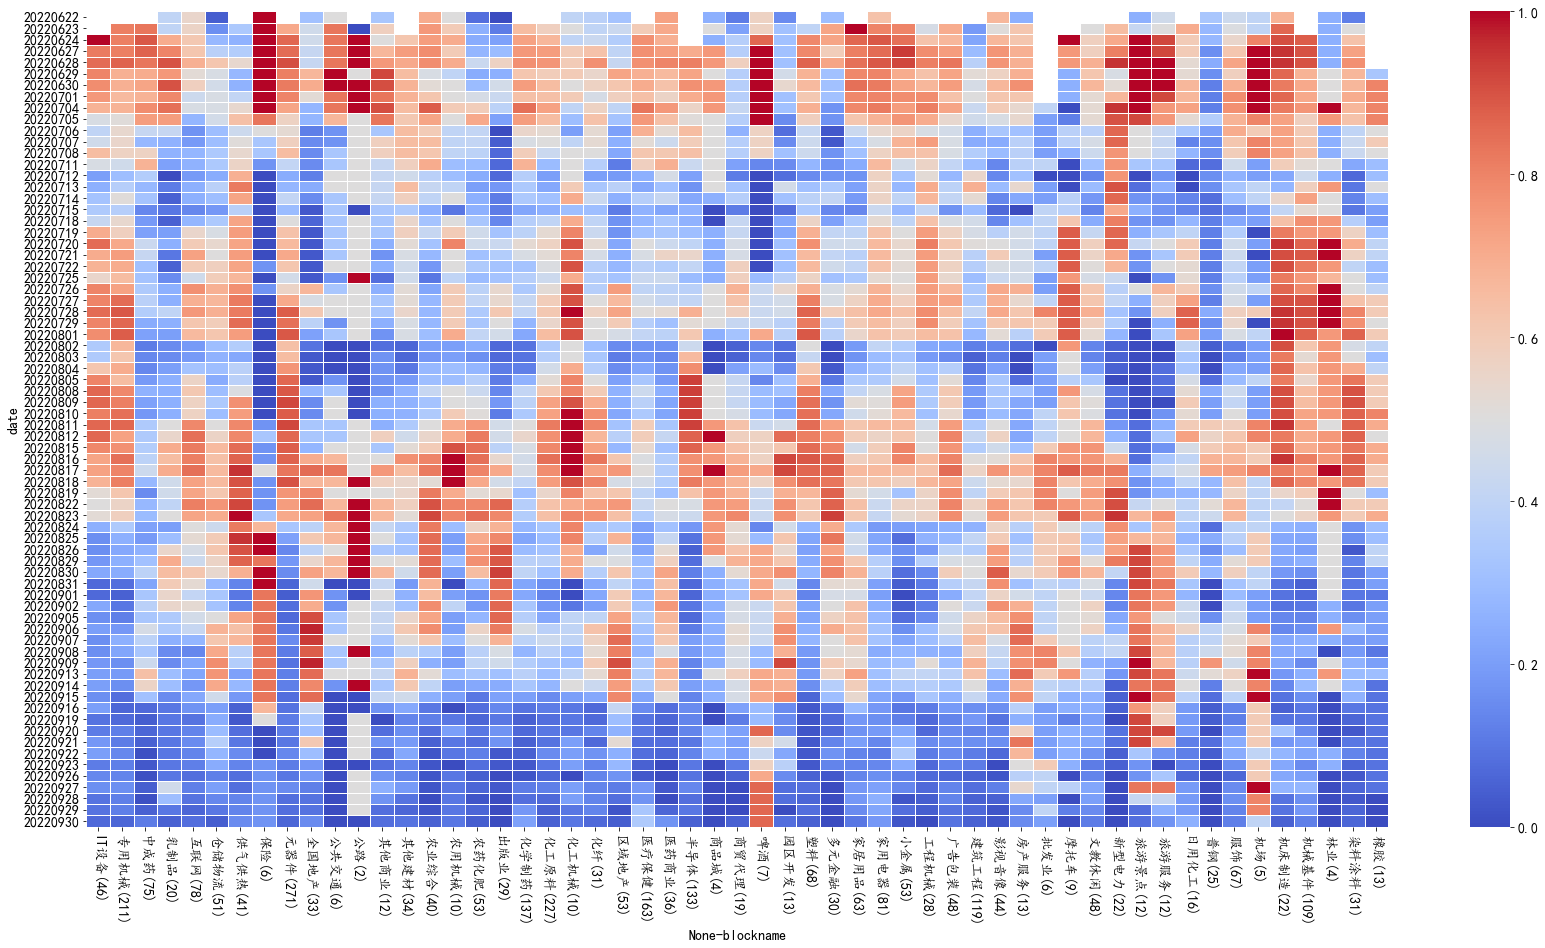

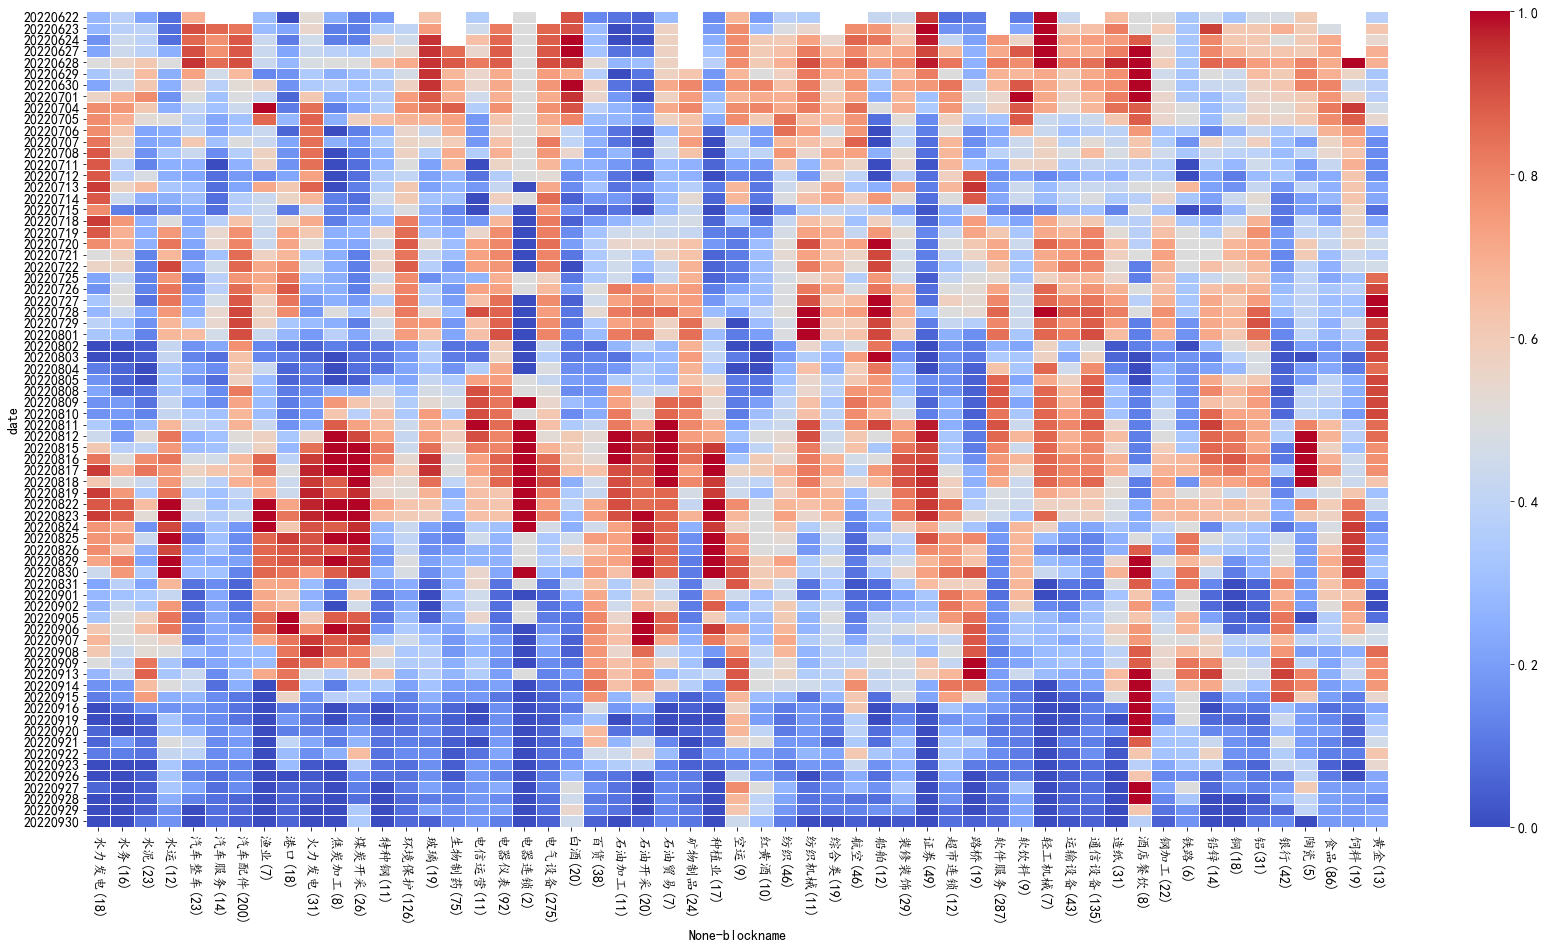

Wall time: 46.9 s


In [2]:
%%time
hy = Block_Trend(hy_source='tdxhy',end='2022-09-30', gap=90, frequence=QA.FREQUENCE.DAY)
hy.fit()
hy.plot()
# QA.QA_util_get_next_day('2021-10-08')

In [11]:
hy.pivot
# hy.trend(absolute=True)

-                                                    ...        \
blockname   IT设备   中成药  仓储物流  供气供热   保险  全国地产 公共交通 其他商业 其他建材  农药化肥  ...    船舶   
date                                                                ...         
1998-06-24   NaN   NaN   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN  ...   NaN   
1998-06-25   NaN   NaN   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN  ...   NaN   
1998-06-26   NaN   NaN   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN  ...   NaN   
1998-06-29   NaN   NaN   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN  ...   NaN   
1998-06-30   NaN   NaN   NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN  ...   NaN   
...          ...   ...   ...   ...  ...   ...  ...  ...  ...   ...  ...   ...   
1998-11-19   NaN  0.67  0.50  0.45  1.0  0.67  0.4  0.4  1.0  0.73  ...  1.00   
1998-11-20   NaN  0.75  0.50  0.45  0.5  0.62  0.6  0.6  0.6  0.55  ...  0.67   
1998-11-23  0.80  0.58  0.50  0.45  0.5  0.57  0.4  0.6  0.4  0.64  ...  0.33   
1998-11-24  0.67  0.58  0.50  0.36  0.5  0.62  0.4  0.6  0.6  0.64  ...  0.33   
1998-11-25  0.17  0.42  0.38  0.36  0.5  0.38  0.4  0.5  0.4  0.27  ...  0.33   

                                                              
blockname     证券 超市连锁    路桥 轻工机械 酒店餐饮   铁路    铅锌    饲料    黄金  
date                                                          
1998-06-24   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN   NaN  
1998-06-25   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN   NaN  
1998-06-26   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN   NaN  
1998-06-29   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN   NaN  
1998-06-30   NaN  NaN   NaN  NaN  NaN  NaN   NaN   NaN   NaN  
...          ...  ...   ...  ...  ...  ...   ...   ...   ...  
1998-11-19  0.67  0.5  0.67  1.0  0.6  0.0  1.00  0.33  0.33  
1998-11-20  0.58  0.0  0.67  1.0  0.4  0.0  1.00  0.67  0.33  
1998-11-23  0.50  0.0  0.67  1.0  0.6  0.0  1.00  0.67  0.33  
1998-11-24  0.42  0.0  0.50  0.5  0.4  0.0  0.67  1.00  0.33  
1998-11-25  0.33  0.0  0.33  0.5  0.2  0.0  0.67  1.00  0.33  

[109 rows x 65 columns]

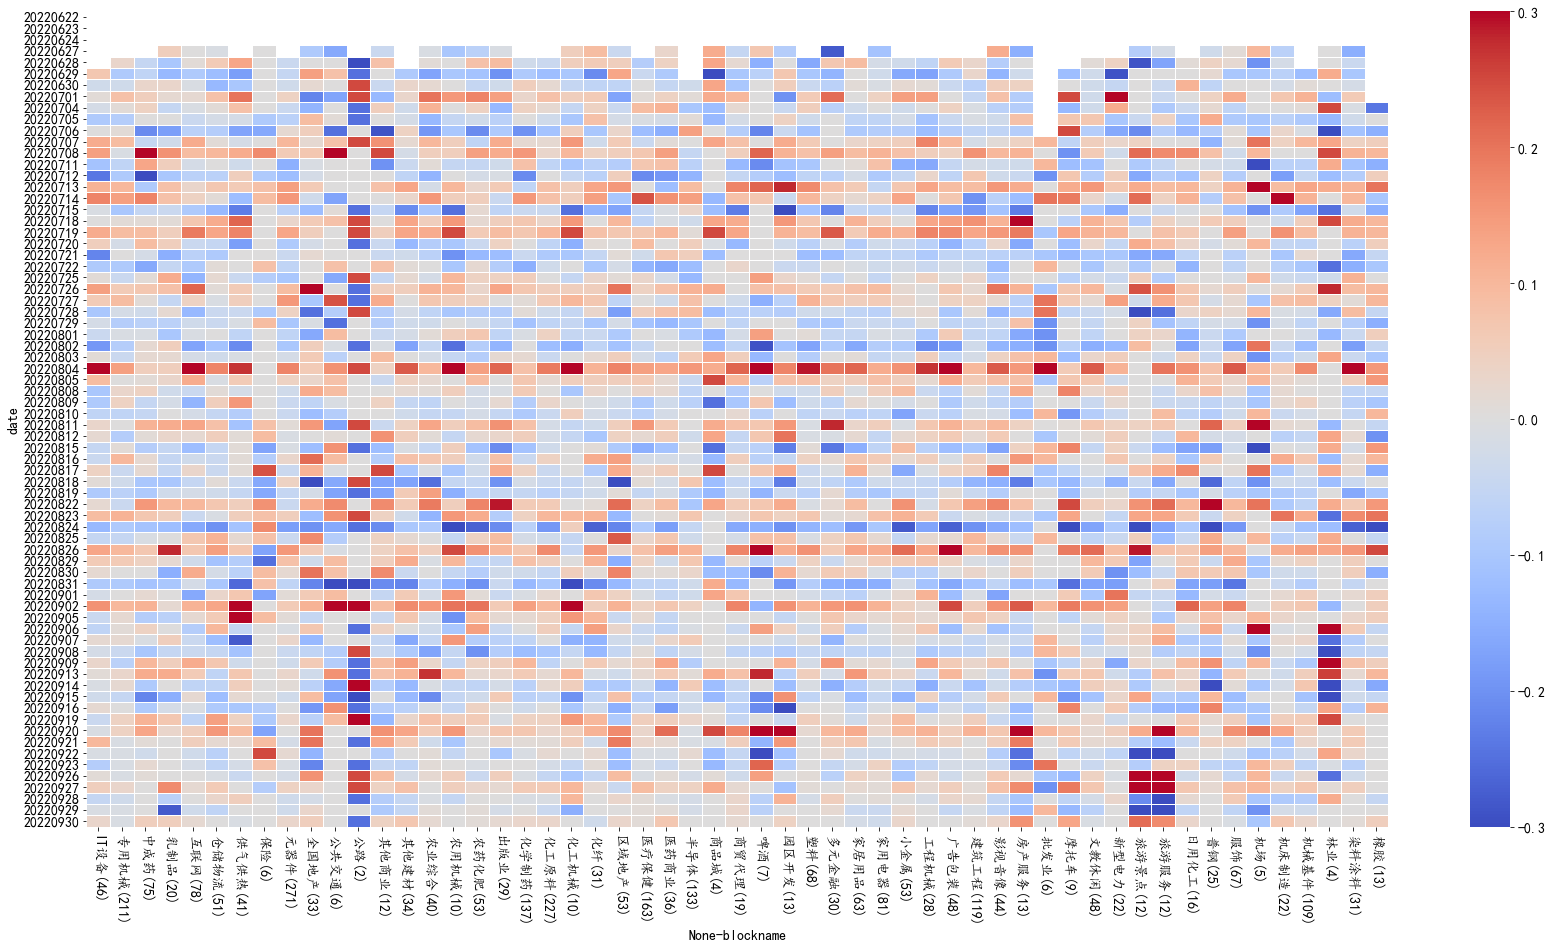

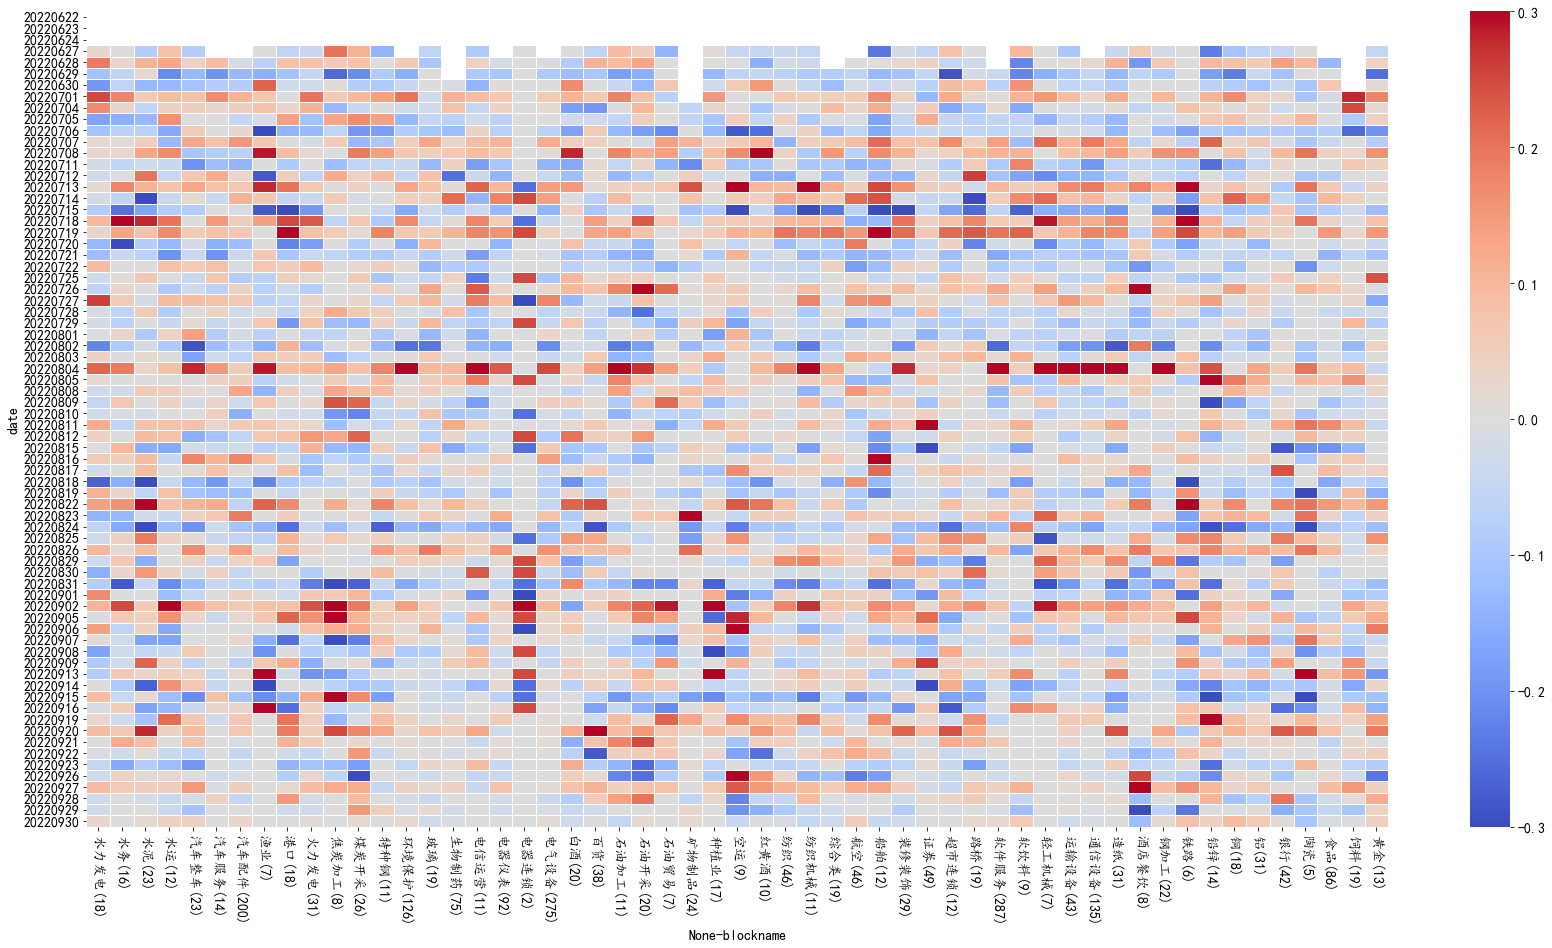

Wall time: 4.88 s


In [3]:
%%time
tr = hy.get_trend(window=5,absolute=False,plot=True)

# print(tr.iloc[-1].sort_values(ascending=False))
# print((tr.iloc[-1].rank(ascending=False,method='first')).sort_values())
# print((tr.loc[['2021-03-18','2021-03-19']].rank(ascending=False,method='first')))

pivot fit finish


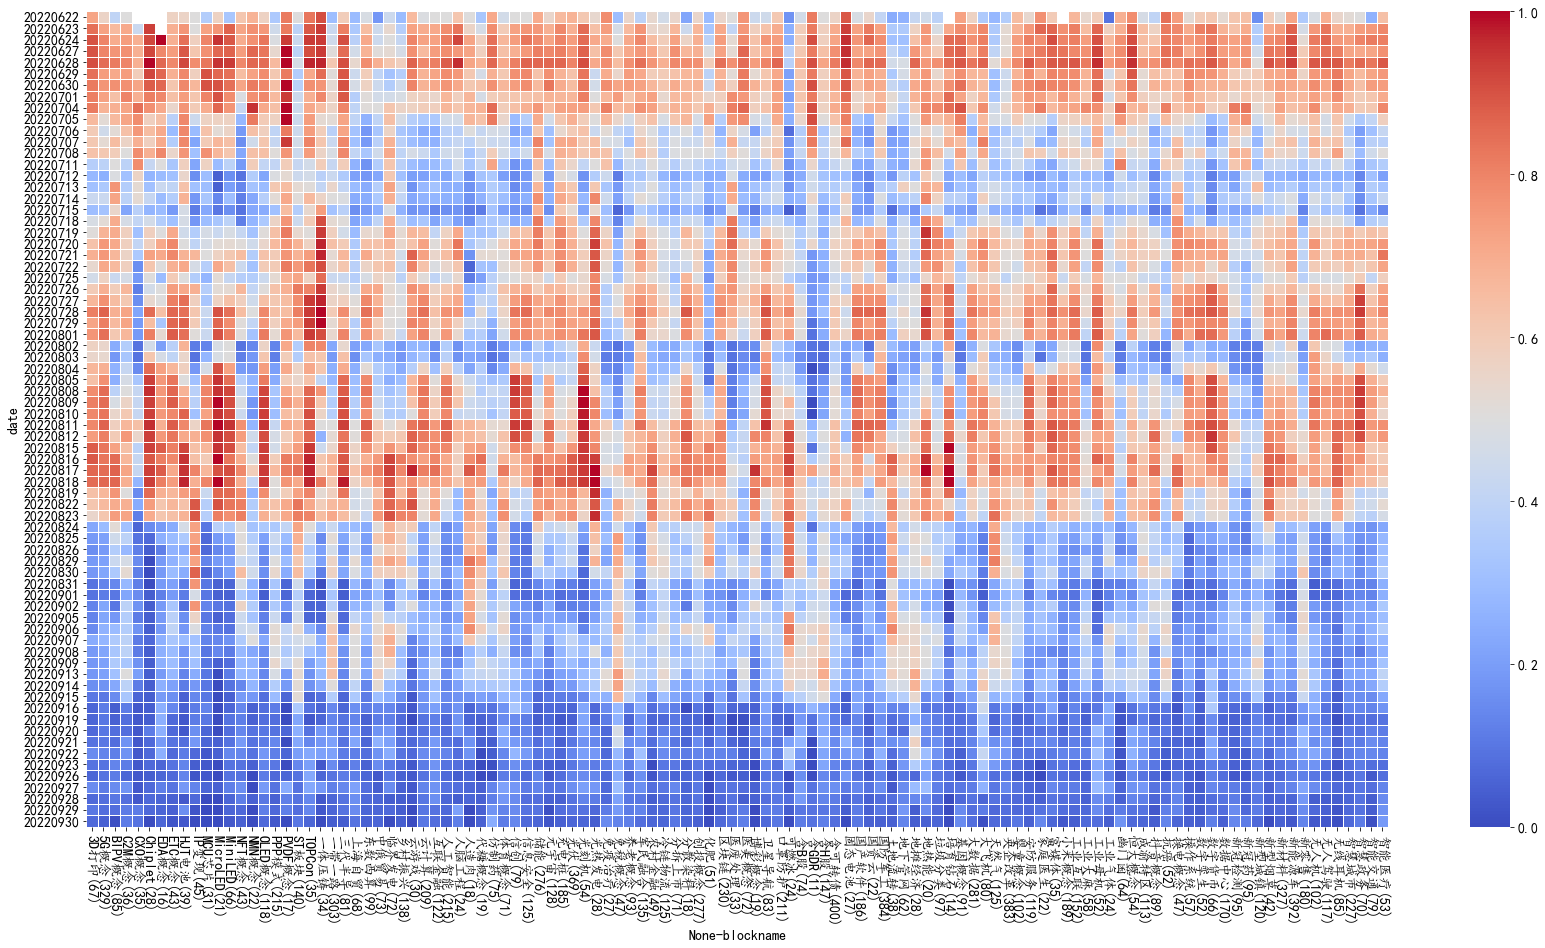

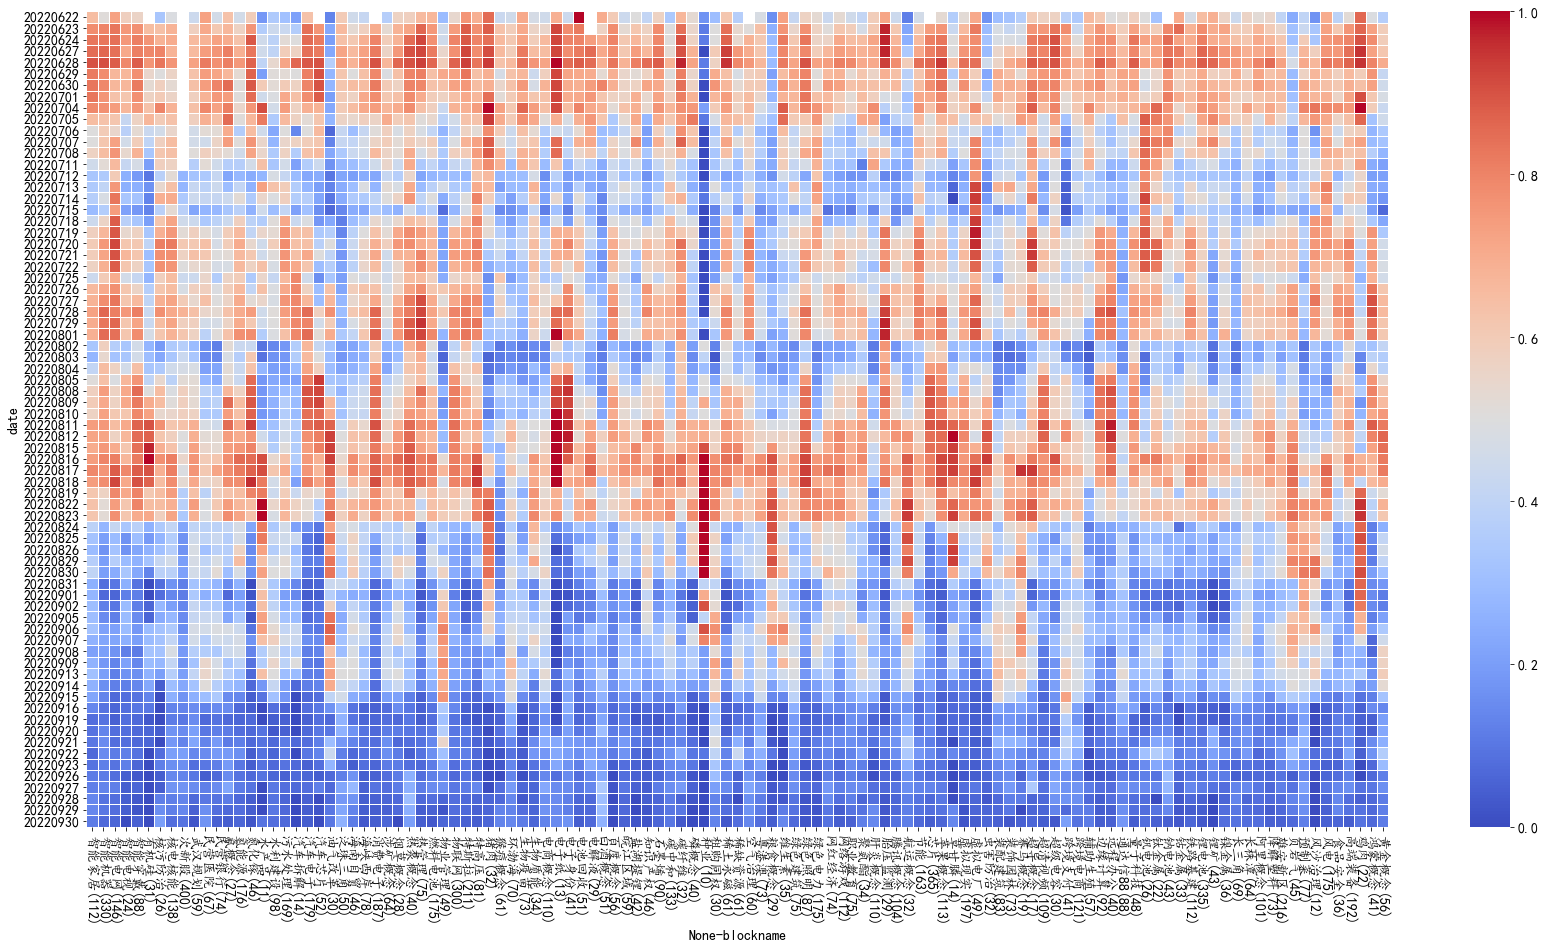

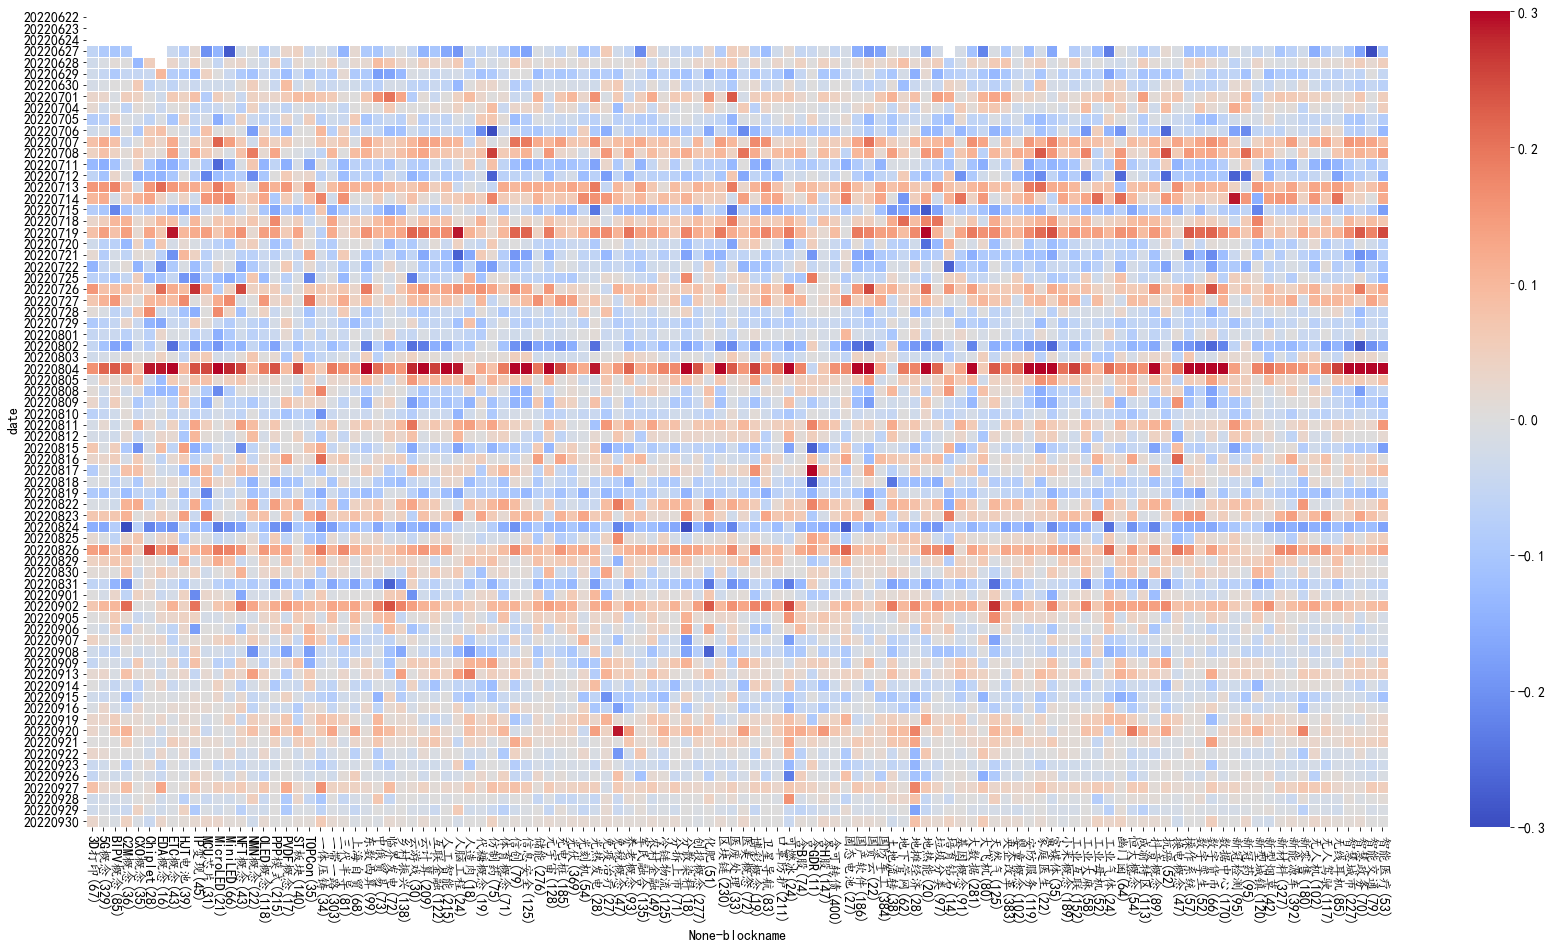

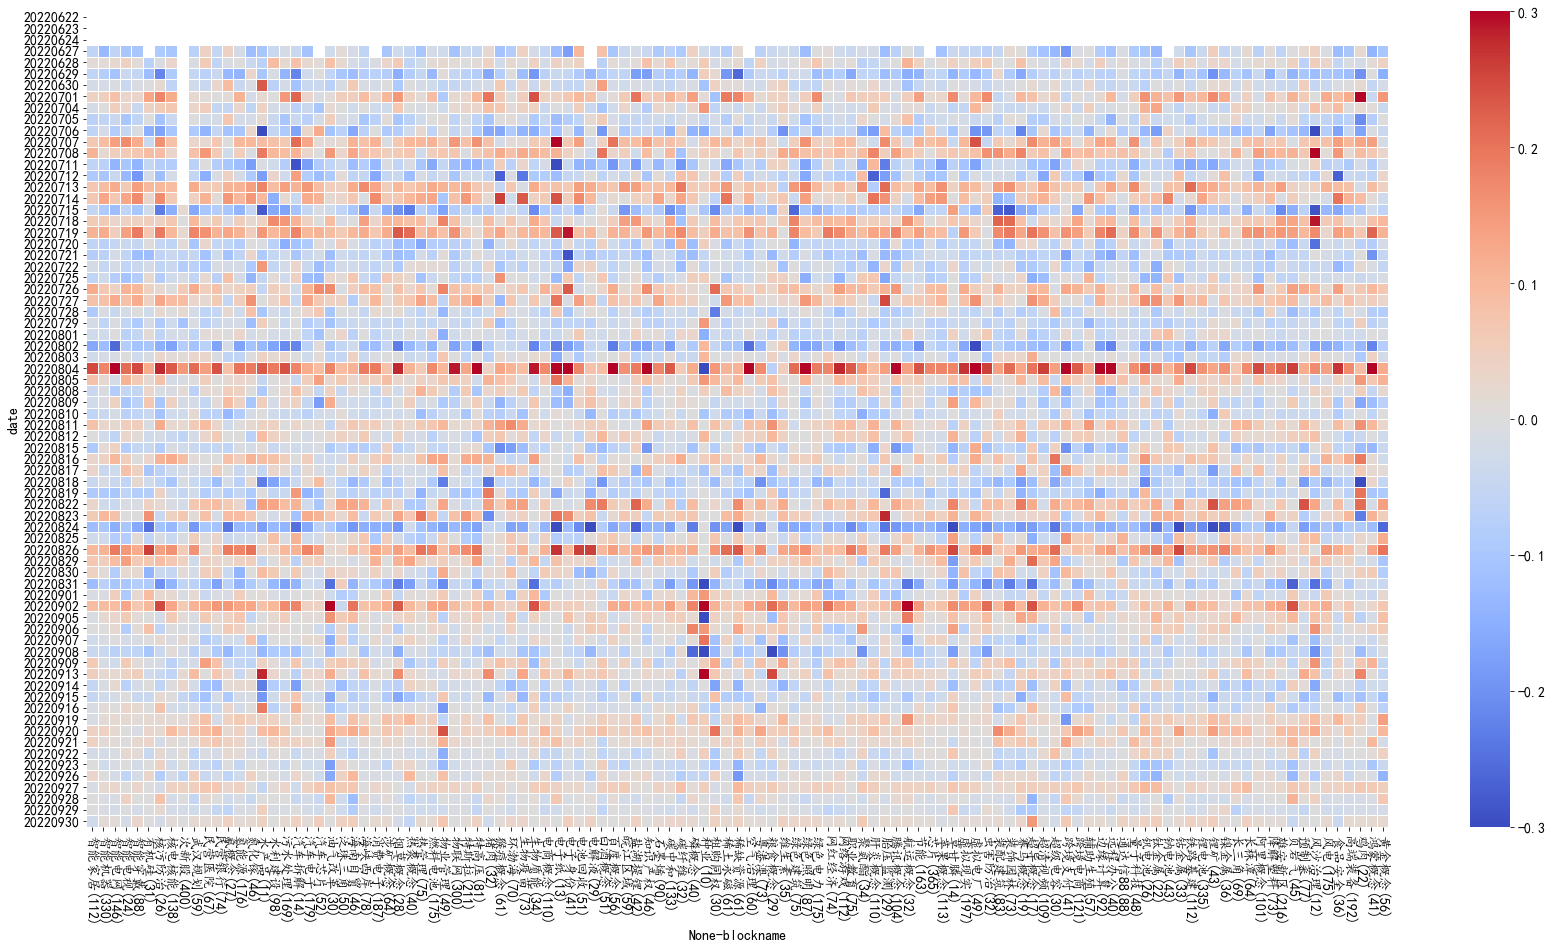

Wall time: 57.1 s


In [4]:
%%time
gn = Block_Trend(hy_source='gn',end='2022-09-30', gap=90, frequence=QA.FREQUENCE.DAY)
gn.fit()
gn.plot()
tr_gn = gn.get_trend(window=5,absolute=False,plot=True)

In [131]:
a = hy.get_trend_rank().index[0]

hy.trend[a]

date
2021-03-03     NaN
2021-03-04     NaN
2021-03-05     NaN
2021-03-08     NaN
2021-03-09     NaN
2021-03-10    0.22
2021-03-11    0.14
2021-03-12    0.00
2021-03-15   -0.07
2021-03-16    0.07
2021-03-17   -0.07
2021-03-18   -0.07
2021-03-19    0.07
2021-03-22    0.00
2021-03-23    0.00
2021-03-24   -0.14
2021-03-25    0.00
2021-03-26    0.14
2021-03-29    0.07
2021-03-30    0.00
2021-03-31   -0.07
2021-04-01    0.00
2021-04-02    0.00
2021-04-06    0.21
2021-04-07    0.01
2021-04-08   -0.51
2021-04-09    0.14
2021-04-12    0.29
2021-04-13   -0.28
2021-04-14    0.07
2021-04-15    0.07
2021-04-16   -0.07
2021-04-19    0.07
2021-04-20    0.00
2021-04-21    0.00
2021-04-22    0.07
2021-04-23    0.07
2021-04-26   -0.21
2021-04-27    0.00
2021-04-28    0.07
2021-04-29   -0.07
2021-04-30    0.14
Name: (-, 陶瓷), dtype: float64

In [17]:
%%time
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     print(tr.iloc[-1].sort_values(ascending=False))
#     print(tr.iloc[-1])
import Sample_Tools as smpl
a = smpl.get_codes_from_blockname('可燃冰')
print(smpl.get_stock_name(a))
# QA.QA_fetch_stock_day_adv(a, '2021-08-05', '2021-08-06').data.sort_index(level=1)

code
000039    中集集团
000554    泰山石油
000852    石化机械
002140    东华科技
002207    准油股份
002221    东华能源
002278    神开股份
002342    巨力索具
002353    杰瑞股份
002554     惠博普
300084    海默科技
300157    恒泰艾普
300164    通源石油
300191    潜能恒信
300228    富瑞特装
300309    吉艾科技
600098    广州发展
600282    南钢股份
600378    昊华科技
600583    海油工程
600871    石化油服
601168    西部矿业
601808    中海油服
603727     博迈科
Name: name, dtype: object
Wall time: 43 ms
